# Question 14: 巡回セールスマン問題 (2) pulp 実装
https://developers.google.com/optimization/routing/tsp

=============================================================================================

問題１４）New Yorkを起点として、以下のリストにある米国１２都市を直線距離で移動する最短ルートを求め、地図上に都市とルートを表示せよ。

New York, Los Angeles, Chicago, Minneapolis, Denver, Dallas, Seattle, Boston,  San Francisco, St. Louis, Houston, Phoenix, Salt Lake City

pulp を用いて問題を解け

=============================================================================================

This section presents an example that shows how to solve the Traveling Salesperson Problem (TSP) for the locations shown on the map below.

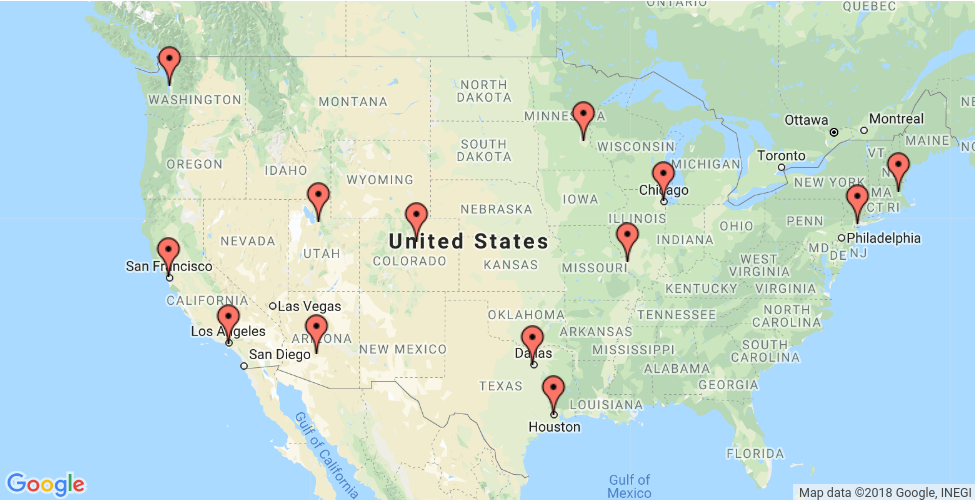

## 必要なライブラリーのColabへのインストール

In [1]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 5.6 MB/s 


In [2]:
!pip install geocoder

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [3]:
# ライブラリーのインポート
from pulp import *
import geocoder
import pandas as pd
import numpy as np
import folium

## データの作成

In [4]:
# 都市の辞書
cities = {0:"New York", 1:"Los Angeles", 2:"Chicago", 3:"Minneapolis", 4: "Denver", 5: "Dallas", 6: "Seattle",
          7: "Boston", 8: "San Francisco", 9: "St. Louis",  10: "Houston", 11: "Phoenix", 12: "Salt Lake City"}

In [5]:
# 辞書からリスト作成
cities.values()

dict_values(['New York', 'Los Angeles', 'Chicago', 'Minneapolis', 'Denver', 'Dallas', 'Seattle', 'Boston', 'San Francisco', 'St. Louis', 'Houston', 'Phoenix', 'Salt Lake City'])

In [6]:
# 都市のリストから経度と緯度のリストを作成する関数
def city2latlon(cities_list):
  # https://qiita.com/yoshi_yast/items/bb75d8fceb712f1f49d1
  lat = []
  lng = []
  for city in cities_list:
    place = city
    ret = geocoder.osm(place, timeout=5.0)
    lat.append(ret.lat)
    lng.append(ret.lng)
  return lat, lng

In [7]:
%%time
lat, lng = city2latlon(cities.values())
print(lat)
print(lng)

[40.7127281, 34.0536909, 41.8755616, 44.9772995, 39.7392364, 32.7762719, 47.6038321, 42.3602534, 37.7790262, 38.6264256, 29.7589382, 33.4484367, 40.7596198]
[-74.0060152, -118.242766, -87.6244212, -93.2654692, -104.9848623, -96.7968559, -122.3300624, -71.0582912, -122.419906, -90.1995853, -95.3676974, -112.0741417, -111.8867975]
CPU times: user 210 ms, sys: 16.1 ms, total: 226 ms
Wall time: 6.26 s


In [8]:
# ２地点間の距離を求める関数
# 参考：https://docs.mlrun.org/en/latest/howto/convert-original-code.html

def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):

    # Define earth radius (km)
    R_earth = 6371
    # Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians, [pickup_lat, pickup_lon, dropoff_lat, dropoff_lon])
    # Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    # Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    # distance
    distance = 2 * R_earth * np.arcsin(np.sqrt(a))
    
    return distance

In [9]:
# 関数の機能確認
print(lat[0], lng[0])
print(lat[3], lng[3])
sphere_dist(lat[0], lng[0], lat[3], lng[3])

40.7127281 -74.0060152
44.9772995 -93.2654692


1635.6855910915033

In [10]:
# 実験：Yew Yorkから各都市への距離のリスト
dist = []
for i in range(len(lat)):
  dist.append(sphere_dist(lat[0], lng[0], lat[i], lng[i]))
dist

[0.0,
 3935.5992910107525,
 1143.8368497114805,
 1635.6855910915033,
 2618.600353345515,
 2205.735949553977,
 3865.410488904645,
 306.16495706242983,
 4128.970699484432,
 1403.2107939118807,
 2281.2804266840712,
 3443.7064452293225,
 3166.318691988919]

In [11]:
# 各距離から別の距離までのリストの二次元リスト
dist_matrix = []
for i in range(len(lat)):
  dist = []
  for j in range(len(lat)):
    dist.append(sphere_dist(lat[i], lng[i], lat[j], lng[j]))
  dist_matrix.append(dist)

print(dist_matrix)

[[0.0, 3935.5992910107525, 1143.8368497114805, 1635.6855910915033, 2618.600353345515, 2205.735949553977, 3865.410488904645, 306.16495706242983, 4128.970699484432, 1403.2107939118807, 2281.2804266840712, 3443.7064452293225, 3166.318691988919], [3935.5992910107525, 0.0, 2804.221269683403, 2448.2623481008454, 1335.7816206072052, 1991.9175580851522, 1544.8676690507998, 4169.504116051552, 559.4154978727139, 2552.270699194701, 2206.4402881334504, 574.1809532337955, 932.7806262356987], [1143.8368497114805, 2804.221269683403, 0.0, 571.150928808991, 1477.6809405735887, 1295.070335403724, 2789.226286685529, 1365.285605759146, 2985.2530466885046, 422.19276245746033, 1515.8417202471257, 2336.7029828914096, 2023.2956578685532], [1635.6855910915033, 2448.2623481008454, 571.150928808991, 0.0, 1123.7371700512806, 1390.326199498663, 2238.849508711896, 1803.8491957502008, 2544.7251091845446, 750.3660565264332, 1702.2069378072251, 2057.4588094552814, 1584.2468468715697], [2618.600353345515, 1335.78162060

In [12]:
# define TSP
n_city = len(cities)
df = pd.DataFrame({'city': cities.values(), 'latitude': lat, 'longitude': lng})
df

,city,latitude,longitude
0,New York,40.712728,-74.006015
1,Los Angeles,34.053691,-118.242766
2,Chicago,41.875562,-87.624421
3,Minneapolis,44.977300,-93.265469
4,Denver,39.739236,-104.984862
5,Dallas,32.776272,-96.796856
6,Seattle,47.603832,-122.330062
7,Boston,42.360253,-71.058291
8,San Francisco,37.779026,-122.419906
9,St. Louis,38.626426,-90.199585


## pulp による解法
参考：https://ie110704.net/2020/08/15/pulp%E3%81%A7%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96%E5%95%8F%E9%A1%8C%EF%BC%88tsp%E3%80%81vrp%EF%BC%89/

In [13]:
# 問題の設定
problem = LpProblem('tsp_mip', LpMinimize)

In [14]:
# 変数の設定
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_city) for j in range(n_city)), lowBound=0, upBound=1, cat='Binary')
print(x)

{(0, 0): x_(0,_0), (0, 1): x_(0,_1), (0, 2): x_(0,_2), (0, 3): x_(0,_3), (0, 4): x_(0,_4), (0, 5): x_(0,_5), (0, 6): x_(0,_6), (0, 7): x_(0,_7), (0, 8): x_(0,_8), (0, 9): x_(0,_9), (0, 10): x_(0,_10), (0, 11): x_(0,_11), (0, 12): x_(0,_12), (1, 0): x_(1,_0), (1, 1): x_(1,_1), (1, 2): x_(1,_2), (1, 3): x_(1,_3), (1, 4): x_(1,_4), (1, 5): x_(1,_5), (1, 6): x_(1,_6), (1, 7): x_(1,_7), (1, 8): x_(1,_8), (1, 9): x_(1,_9), (1, 10): x_(1,_10), (1, 11): x_(1,_11), (1, 12): x_(1,_12), (2, 0): x_(2,_0), (2, 1): x_(2,_1), (2, 2): x_(2,_2), (2, 3): x_(2,_3), (2, 4): x_(2,_4), (2, 5): x_(2,_5), (2, 6): x_(2,_6), (2, 7): x_(2,_7), (2, 8): x_(2,_8), (2, 9): x_(2,_9), (2, 10): x_(2,_10), (2, 11): x_(2,_11), (2, 12): x_(2,_12), (3, 0): x_(3,_0), (3, 1): x_(3,_1), (3, 2): x_(3,_2), (3, 3): x_(3,_3), (3, 4): x_(3,_4), (3, 5): x_(3,_5), (3, 6): x_(3,_6), (3, 7): x_(3,_7), (3, 8): x_(3,_8), (3, 9): x_(3,_9), (3, 10): x_(3,_10), (3, 11): x_(3,_11), (3, 12): x_(3,_12), (4, 0): x_(4,_0), (4, 1): x_(4,_1), (4,

In [15]:
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_city)), lowBound=1, upBound=n_city, cat='Integer')
print(u)

{0: u_0, 1: u_1, 2: u_2, 3: u_3, 4: u_4, 5: u_5, 6: u_6, 7: u_7, 8: u_8, 9: u_9, 10: u_10, 11: u_11, 12: u_12}


In [16]:
# 目的関数の設定
problem += lpSum(dist_matrix[i][j] * x[i, j] for i in range(n_city) for j in range(n_city))

x_{i,j} が i から j に移動する場合は1, そうでない場合は0とする決定変数となり、problem += lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)) で、x_{i,j}=1 の場合にその区間の距離 distance_{i,j} をかけて総移動距離を計算し、これを最小化しています。

In [17]:
# 制約条件
for i in range(n_city):
    problem += x[i, i] == 0

for i in range(n_city):
    problem += lpSum(x[i, j] for j in range(n_city)) == 1
    problem += lpSum(x[j, i] for j in range(n_city)) == 1

制約条件のパートでは、同じ都市への移動はありませんので、x_{i, i} = 0.
都市間の区間は必ず1回だけ通るという制約を入れています。

In [18]:
# subtourの排除
for i in range(n_city):
    for j in range(n_city):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_city * (1 - x[i, j]) - 1

subtourの排除では、部分巡回経路ができてしまわないように制御しています。

In [19]:
print(problem)

tsp_mip:
MINIMIZE
3935.5992910107525*x_(0,_1) + 2281.2804266840712*x_(0,_10) + 3443.7064452293225*x_(0,_11) + 3166.318691988919*x_(0,_12) + 1143.8368497114805*x_(0,_2) + 1635.6855910915033*x_(0,_3) + 2618.600353345515*x_(0,_4) + 2205.735949553977*x_(0,_5) + 3865.410488904645*x_(0,_6) + 306.16495706242983*x_(0,_7) + 4128.970699484432*x_(0,_8) + 1403.2107939118807*x_(0,_9) + 3935.5992910107525*x_(1,_0) + 2206.4402881334504*x_(1,_10) + 574.1809532337955*x_(1,_11) + 932.7806262356987*x_(1,_12) + 2804.221269683403*x_(1,_2) + 2448.2623481008454*x_(1,_3) + 1335.7816206072052*x_(1,_4) + 1991.9175580851522*x_(1,_5) + 1544.8676690507998*x_(1,_6) + 4169.504116051552*x_(1,_7) + 559.4154978727139*x_(1,_8) + 2552.270699194701*x_(1,_9) + 2281.2804266840712*x_(10,_0) + 2206.4402881334504*x_(10,_1) + 1632.4251113848238*x_(10,_11) + 1929.5937324058295*x_(10,_12) + 1515.8417202471257*x_(10,_2) + 1702.2069378072251*x_(10,_3) + 1413.5918852584166*x_(10,_4) + 361.9528081344039*x_(10,_5) + 3040.4900655836636

In [20]:
%%time
# 解く
status = problem.solve()

CPU times: user 124 ms, sys: 19.5 ms, total: 143 ms
Wall time: 16 s


In [21]:
status, LpStatus[status], value(problem.objective)

(1, 'Optimal', 11594.34900618699)

In [22]:
# 結果表示
print(LpStatus[status])
print("総距離：" + str(value(problem.objective)) + "km")

Optimal
総距離：11594.34900618699km


In [23]:
routes_matrix = [(i, j) for i in range(n_city) for j in range(n_city) if value(x[i, j]) == 1]
routes_matrix

[(0, 9),
 (1, 8),
 (2, 7),
 (3, 2),
 (4, 3),
 (5, 10),
 (6, 12),
 (7, 0),
 (8, 6),
 (9, 5),
 (10, 11),
 (11, 1),
 (12, 4)]

In [24]:
routes = [0]
for i in range(n_city):
  for j in range(n_city):
    if routes[i] == routes_matrix[j][0]:
      routes.append(routes_matrix[j][1])
routes

[0, 9, 5, 10, 11, 1, 8, 6, 12, 4, 3, 2, 7, 0]

In [25]:
route_cities = [df["city"][i] for i in routes]
route_cities

['New York',
 'St. Louis',
 'Dallas',
 'Houston',
 'Phoenix',
 'Los Angeles',
 'San Francisco',
 'Seattle',
 'Salt Lake City',
 'Denver',
 'Minneapolis',
 'Chicago',
 'Boston',
 'New York']

Google OR-Tools とは逆周りですが、実質同じ解となりました。

## 最適ルートを地図上に可視化

In [26]:
%%time
# 最適ルート順の都市の緯度、経度のリスト作成
lat, lng = city2latlon(route_cities)
print(lat)
print(lng)

[40.7127281, 38.6264256, 32.7762719, 29.7589382, 33.4484367, 34.0536909, 37.7790262, 47.6038321, 40.7596198, 39.7392364, 44.9772995, 41.8755616, 42.3602534, 40.7127281]
[-74.0060152, -90.1995853, -96.7968559, -95.3676974, -112.0741417, -118.242766, -122.419906, -122.3300624, -111.8867975, -104.9848623, -93.2654692, -87.6244212, -71.0582912, -74.0060152]
CPU times: user 288 ms, sys: 22.8 ms, total: 311 ms
Wall time: 6.97 s


In [27]:
# データ格納（名前，緯度経度）
df = pd.DataFrame({
    'location': route_cities,
    'latitude': lat,
    'longtude': lng
})

# 地図生成（アメリカ）
folium_map = folium.Map(location=[39.000 , -98.500], zoom_start=4)

# マーカープロット
for i, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longtude']],
        popup=row['location'],
        icon=folium.Icon(color='red')
    ).add_to(folium_map)

locations = list([(lat[i], lng[i]) for i in range(len(lat))])
folium.PolyLine(locations=locations,color="blue").add_to(folium_map)

# 地図表示
folium_map

## Folium アニメーション

In [28]:
# points   = []
features = []
for la, ln, city, i in zip(lat, lng, route_cities, range(len(route_cities))):
  if i <9:
    d = "0" + str(i+1)
  else:
    d = str(i+1)
  features.append({'type': 'Feature',
                    'geometry': {'type': "Point",
                                'coordinates': [ln,la]},
                    'properties': {'time': "2022-01-"+ d,
                                  'popup':"<h6 style=\'color:black;\'>" + city + "<h6>",
                                  'icon': 'circle',
                                  'iconstyle': {'color': "red",
                                  'fill': True,
                                  'radius': 8
                                  },
                                  'style': {'fillOpacity': 1,
                                            'weight': 1}
                                  }
                  }
                  )

In [29]:
features

[{'geometry': {'coordinates': [-74.0060152, 40.7127281], 'type': 'Point'},
  'properties': {'icon': 'circle',
   'iconstyle': {'color': 'red', 'fill': True, 'radius': 8},
   'popup': "<h6 style='color:black;'>New York<h6>",
   'style': {'fillOpacity': 1, 'weight': 1},
   'time': '2022-01-01'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-90.1995853, 38.6264256], 'type': 'Point'},
  'properties': {'icon': 'circle',
   'iconstyle': {'color': 'red', 'fill': True, 'radius': 8},
   'popup': "<h6 style='color:black;'>St. Louis<h6>",
   'style': {'fillOpacity': 1, 'weight': 1},
   'time': '2022-01-02'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-96.7968559, 32.7762719], 'type': 'Point'},
  'properties': {'icon': 'circle',
   'iconstyle': {'color': 'red', 'fill': True, 'radius': 8},
   'popup': "<h6 style='color:black;'>Dallas<h6>",
   'style': {'fillOpacity': 1, 'weight': 1},
   'time': '2022-01-03'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-95.3676974, 29.758

In [30]:
from folium.plugins import TimestampedGeoJson

# 地図生成（アメリカ）
folium_map = folium.Map(location=[39.000 , -98.500], zoom_start=4)

locations = list([(lat[i], lng[i]) for i in range(len(lat))])
folium.PolyLine(locations=locations,color="blue").add_to(folium_map)

# https://python-visualization.github.io/folium/plugins.html?highlight=animation#:~:text=class%20folium.plugins.TimestampedGeoJson
TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='P1D', # P1D -> 1/day
    add_last_point=False,
    auto_play=True,
    loop=True,
    max_speed=10,
    loop_button=True,
    date_options='YYYY/MM/DD',
    transition_time=3000
).add_to(folium_map)

folium_map

In [31]:
folium_map.save('TSP_folium_map2.html')